In [1]:
import xarray as xr
import numpy  as np
# import seaborn as sns
import proplot as pplt
import pandas as pd
import matplotlib.pyplot as plt

2021.04.19

进行分区之后的绘制脚本，分区在此前已经由cdo完成

计算采用同目录下的 timeseries_count.py 使用import进行导入之后使用，其中进行了五天的滑动平均

将计算结果保存到 partial_mean partial_std 之中，作为字典整理为pandas，进行timeseries的绘图

2021.08.16

更大区域，新增两个分区，考虑使用proplot进行绘图

In [2]:
from timeseries_count import *

# get partial mask_res collect into a dict
partial_list = ["NE", "NC", "YZ", "SC",'SW','NWC']
path_in = "/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre"
file_ref= "obsmerge_pre_98-17.nc"
file_vr = "vr_pre_98-17.nc"
file_rcm = "rcm_pre_98-17.nc"
partial_mean = {} # partial mask_res
partial_std = {} # partial mask_res
var = {}
for iregion in partial_list:
    ds_or = {}
    var[iregion] = {}
    path_in_partial = path_in + "/" + iregion + "/ydaymean/" # refine path
    print(path_in_partial)
    ds_or['obs'] = xr.open_dataset(path_in_partial + file_ref)
    ds_or['vr']     = xr.open_dataset(path_in_partial + file_vr)
    ds_or['rcm']    = xr.open_dataset(path_in_partial + file_rcm  )
    # 提取变量
    var[iregion]['obs'] = ds_or['obs']['premerge']#[:,  :, :]
    var[iregion]['vr'] = ds_or['vr']['precip_MPAS']
    var[iregion]['rcm'] = ds_or['rcm']['precip_MPAS']

    var[iregion]['obs'] = var[iregion]['obs'].reset_coords(names = 'lev', drop = True) # 去除掉obs中多余的lev coords

    # change coords
    var_list = ['obs', 'vr', 'rcm']
    for i in var_list:
        rename_dict = dict(zip(var[iregion][i].coords.keys(), var[iregion]['obs'].coords.keys()))
    #     # show converting coords
        for rename_i in rename_dict:
            print(rename_i + " -----converting to----- " + rename_dict[rename_i])

        var[iregion][i] = var[iregion][i].rename(rename_dict)
        var[iregion][i]._coords = var[iregion]['obs']._coords
        var[iregion][i] = var[iregion][i].rename(i)


/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre/NE/ydaymean/
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre/NC/ydaymean/
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
Time -----converting to----- time
longitude -----converting to----- lon
latitude -----converting to----- lat
/raid52/yycheng/MPAS/REFERENCE/TEMP_DATA_large/partial_pre/YZ/ydaymean/
time -----converting to----- time
lon -----converting to----- lon
lat -----converting to----- lat
Time -----converting to----- time
longitude -----conve

In [3]:
var_ts_rmean = {}
var_list = ['obs', 'vr', 'rcm']
for iregion in partial_list:
    var_ts_rmean[iregion] = {}
    for imod in var_list:
        var_ts_rmean[iregion][imod] = var[iregion][imod].mean(dim=['lat','lon']).rolling(time=5, center=True).mean()


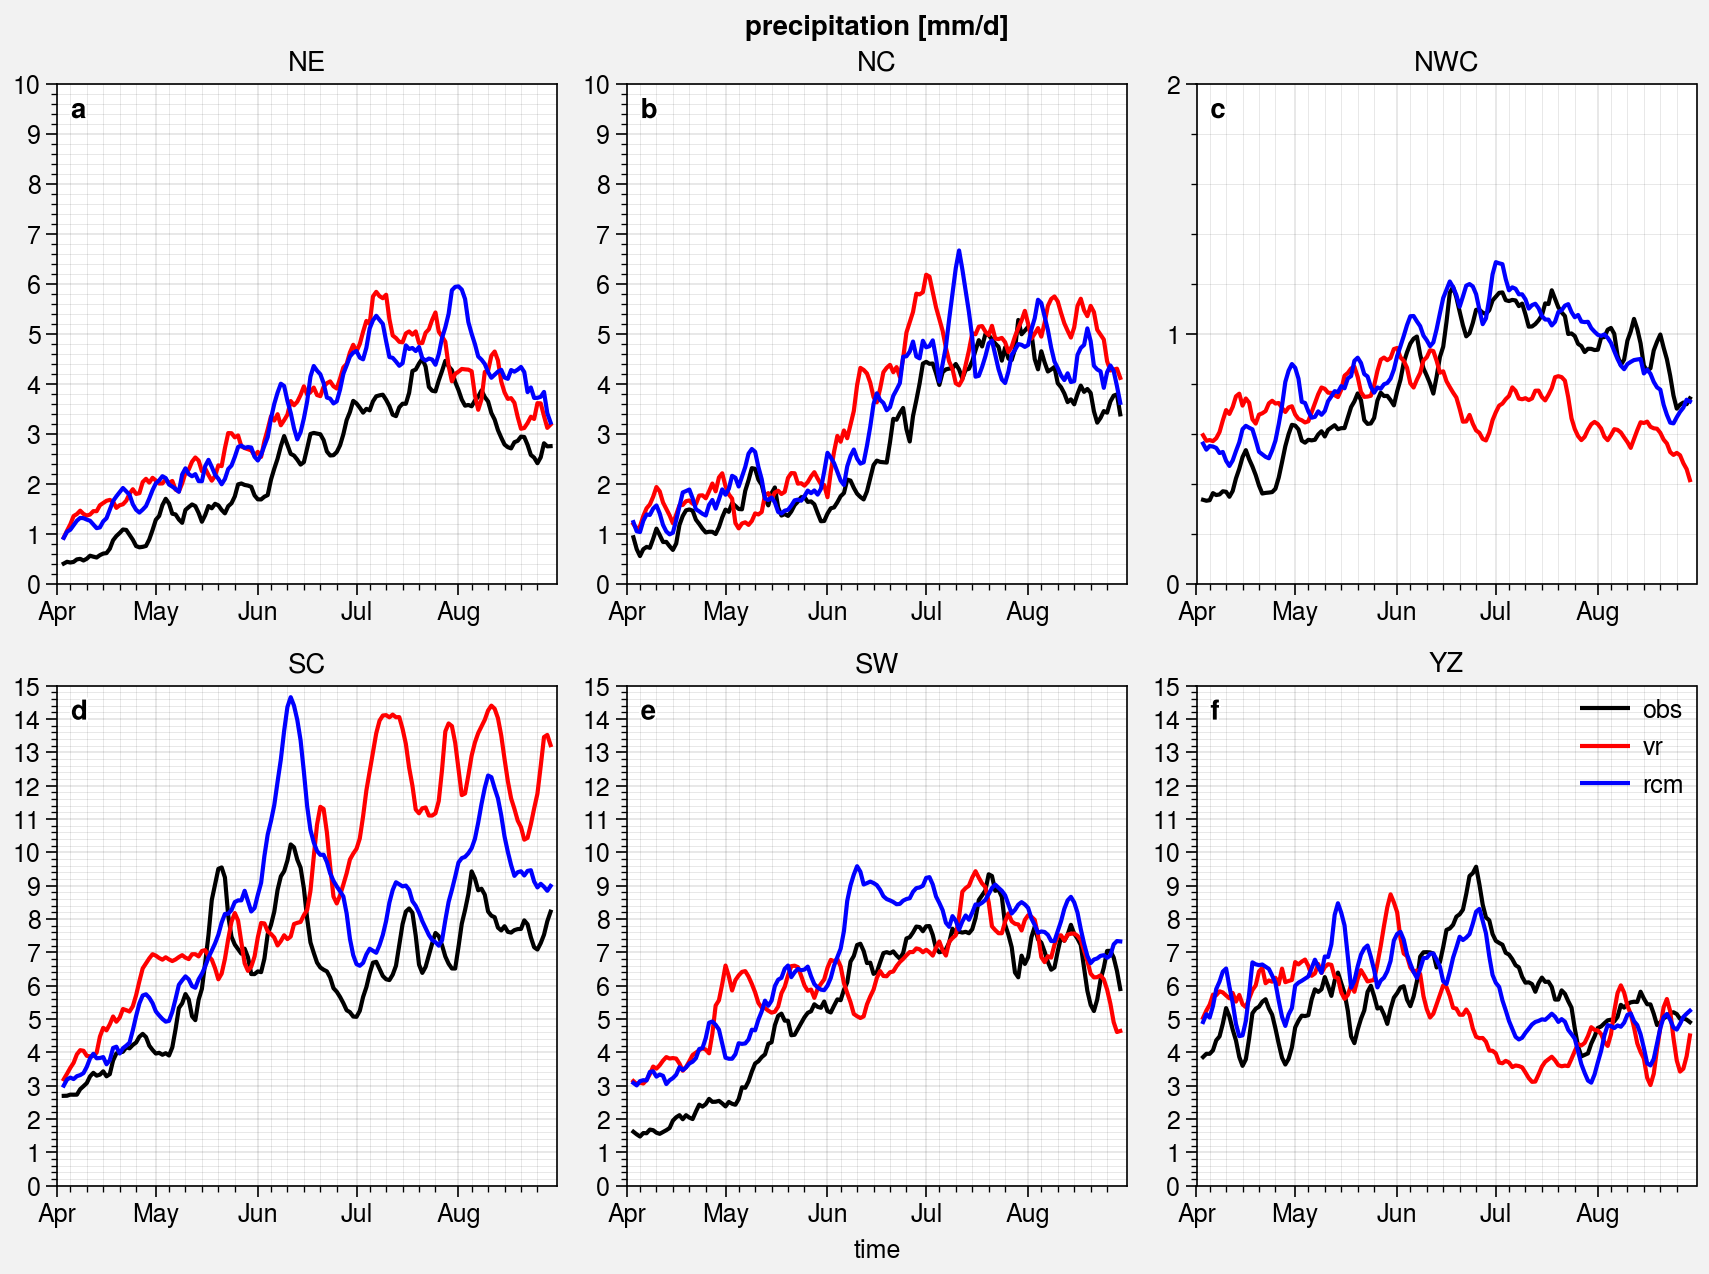

In [4]:
from matplotlib import pyplot as plt
import proplot as pplt
# ----- get filter vars coords-----
partial_list = ["NE", "NC", "NWC", "SC",'SW','YZ']
#----- create plot -----
fig, axs = pplt.subplots(ncols=3 ,nrows=2, share=1)
for axs_idx, iregion in enumerate( partial_list ):
    obs_plot = axs[axs_idx].plot(var_ts_rmean[iregion]['obs'].time, var_ts_rmean[iregion]['obs'].values, color = 'k', label = 'obs')
    vr_plot  = axs[axs_idx].plot(var_ts_rmean[iregion]['vr'].time, var_ts_rmean[iregion]['vr'].values, color = 'r', label = 'vr')
    rcm_plot = axs[axs_idx].plot(var_ts_rmean[iregion]['rcm'].time, var_ts_rmean[iregion]['rcm'].values, color = 'b', label = 'rcm')
    axs[axs_idx].format(
        abc = True,
        abcloc = 'ul',
        # -----
        xlim=(np.datetime64('2017-04-01'), np.datetime64('2017-08-31')),
        ylim = (0,15.),
        ylocator = 1.,
        # yminorlocator = np.arange(0,1.4,0.1),
        yminorlocator = 0.2,
        # ----- time ticks setting -----
        xrotation = False,
        xgrid = True,
        xgridminor = True,
        ygridminor = True,
        xminorlocator=('day',range(0,30,5)),
        xlocator=('month',range(0,12,1)),
        xformatter = '%b', #title='Ticks every N units',
        title = iregion,
        suptitle = 'precipitation [mm/d]'
    )
# ----- add legend -----
axs[5].legend([obs_plot,vr_plot,rcm_plot], loc='ur', ncols=1, frame=False)
# ----- setting limit -----
axs[0:2].format(ylim = (0,10))
axs[2].format(ylim = (0,2))
axs[5].format(ylim = (0,15))

# saving figs
plt.savefig("./output_pic/pre_ts_6region_pplt.png", dpi = 600, facecolor = "white")